# Import and Utils

In [32]:
import replicate
from tqdm import tqdm
import random
import os
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
import numpy as np
import re
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
## model

import pickle

In [2]:
os.environ["REPLICATE_API_TOKEN"] = "YOUR_API_KEY"
api = replicate.Client(api_token=os.environ["REPLICATE_API_TOKEN"])

In [3]:

PARAMS = dict({

	'train_on': [2015, 2017, 2018, 2016, 2019],
	'test_on': [2020, 2021, 2023, 2022, 2024],

	'epochs': 60,
	'LR': 0.95e-4,

	'Pred_period': '3m',
	'Zero-Shot': 0,
	'Fine_Tune': 1,
	"save_dir": './3m.txt'
	})

RESULTS = []


QUESTION = """\nBased on the information above, response with [UP] if the \
price is going up in 3 months or [DOWN] if the price is going down in 3 months. Response:"""

INSTRUCTION = """You are a financial advisor and you want to determin if a company worth \
investing in. Summary of news articles, historic price data, and last four quarter \
financial reports data in tab-separated table for a specefic company is given bellow. \
Based on the given information, predict if the stock price is going up or down at the \
end of the next quarter, in 3 months. Give a one word response with either [UP] or [DOWN].\n"""



# Prompting Functions

In [4]:

def extract_float(text):
		match = re.search(r"[-+]?\d*\.\d+", text)
		if match:
				return float(match.group(0))
		else:
				return None

def r4(value):
	if isinstance(value, float):
		# If the input is a single float, round it and format it to 4 decimal places
		return f"{round(value, 3):.3f}"
	else:
		value = list(value)
		return [f"{round(v, 3):.3f}" for v in value]

def evaluate(y_test, y_pred, roundd = False, arrayed = False):
	print(precision_recall_fscore_support(y_test, y_pred))    
	[pp, pn] = list(precision_recall_fscore_support(y_test, y_pred)[0])
	[rp, rn] = list(precision_recall_fscore_support(y_test, y_pred)[1])
	[fp, fn] = list(precision_recall_fscore_support(y_test, y_pred)[2])
	wf1 = f1_score(y_test, y_pred, average = 'weighted')
	acc = accuracy_score(y_test, y_pred)
	mcc = matthews_corrcoef(y_test, y_pred)
	if roundd:
		[pp, pn] = [r4(pp), r4(pn)]
		[rp, rn] = [r4(rp), r4(rn)]
		[fp, fn] = [r4(fp), r4(fn)]
		wf1 = r4(wf1)
		acc = r4(acc)
		mcc = r4(mcc)
	
	
	res =  {'P+-': [pp, pn],\
			'R+-': [rp, rn],\
			'f1s': [fp, fn],\
			'wf1': wf1,\
			'ACC': acc,\
			'MCC': mcc}
	
	if arrayed:
		return [pp, pn, rp, rn, fp, fn, wf1, acc, mcc]
	return res

def np_ratio(arr):
	ar = []
	for i in arr:
		if i == '[UP]':
			ar.append(1)
		else:
			ar.append(0)
	C = Counter(ar)
	return 'Neg: ' + str(C[0]/(C[1]+C[0])) + ' Pos: ' + str(C[1]/(C[1]+C[0])) 

def evaluator(test_data, model):
	generated_output = []
	real_output = []
	for i in tqdm(test_data):
		input = {
			"top_p": 1,
			"prompt": i['input'],
			"temperature": 0.25,
			"system_prompt": INSTRUCTION,
			"max_new_tokens": 20,
			"repetition_penalty":1.25
		}
		output = api.run(model,input=input)
		output = ''.join(output)
		if 'up' in output.lower() and 'down' in output.lower():
			out_bin = None
		elif 'up' in output.lower():
			out_bin = 1.0
		elif 'down' in output.lower():
			out_bin = 0.0
		else:
			out_bin = None

		benchmark = 1.0 if 'up' in i["output"].lower() else 0.0
		# print(benchmark, out_bin)
		generated_output.append(out_bin)
		real_output.append(benchmark)

	valid_indices = [i for i, output in enumerate(generated_output) if output is not None]
	generated_output_filtered = np.array([generated_output[i] for i in valid_indices])
	real_output_filtered = np.array([real_output[i] for i in valid_indices])
	print('validated generations:', len(generated_output_filtered)/len(test_data))
	res = evaluate(real_output_filtered, generated_output_filtered)
	print('in evaluator', res)
	return res, (real_output_filtered, generated_output_filtered)

def get_dataset(target, train_years, test_years, bin_targets = True, dir = '../prompts/full/'):
	train_datas = []
	test_datas = []

	for comptick in os.listdir(dir):
		if comptick.split('.')[-1]=='pkl':
			with open(dir+comptick, 'rb') as f:
				data = pickle.load(f)
				if not len(data):
					continue
				ticker = comptick.split('.')[-2]
				#data = [dict(zip(data.keys(), values)) for values in zip(*data.values())]
				for i in data:
					target_datum = i['targets_bin'][target] if bin_targets else i['targets'][target]
					target_datum = '[UP]' if target_datum else '[DOWN]'
					datum = {'instruction': INSTRUCTION,
			  				'input': i['prompt'] + QUESTION,
			  				'output': target_datum,
							'ticker': ticker,
							'date': i['date']}
					if int(i['date'].split('-')[0]) in train_years:
						train_datas.append(datum)
					elif int(i['date'].split('-')[0]) in test_years:
						test_datas.append(datum)
	random.shuffle(train_datas)
	random.shuffle(test_datas)
	return train_datas, test_datas

def logger(res, model = 'LLaMA3-8B'):
	resu = {}
	resu['model'] = model
	for i in res.keys():
		resu[i] = res[i]
	RESULTS.append(resu)


# Loading data and Prompting

In [5]:
train_dict, test_dict = \
	get_dataset(target = PARAMS['Pred_period'], train_years = PARAMS['train_on'], test_years=PARAMS['test_on'])

len(test_dict), len(train_dict)

(4972, 5071)

In [6]:
print(INSTRUCTION + test_dict[0]['input'], len(test_dict))

You are a financial advisor and you want to determin if a company worth investing in. Summary of news articles, historic price data, and last four quarter financial reports data in tab-separated table for a specefic company is given bellow. Based on the given information, predict if the stock price is going up or down at the end of the next quarter, in 3 months. Give a one word response with either [UP] or [DOWN].
The Coca-Cola Company is a multinational beverage company that produces and sells a variety of non-alcoholic beverages, including its flagship Coca-Cola, along with juices, teas, and energy drinks.
News Summaries:
- McDonald's, Coca-Cola, and Starbucks halt sales in Russia
- Coca-Cola UNITED opens a new sales center in Panama City
- Coke's parent company, Swire Pacific, reports a profit thanks to their Coca-Cola unit
- U.S. food companies and fast-food chains stay open in Russia but remain quiet about Ukraine

Financial data for last four quarters from old to new:
dates:	2021

In [7]:
res, stats = evaluator(test_dict, "meta/meta-llama-3-8b")

100%|██████████| 4972/4972 [1:00:50<00:00,  1.36it/s] 

validated generations: 0.9796862429605793
(array([0.41891892, 0.57781794]), array([0.09051095, 0.90838068]), array([0.14885954, 0.70633715]), array([2055, 2816]))
in evaluator {'P+-': [0.4189189189189189, 0.577817935396431], 'R+-': [0.0905109489051095, 0.9083806818181818], 'f1s': [0.14885954381752703, 0.706337153113351], 'wf1': 0.4711459219281902, 'ACC': 0.5633340176555122, 'MCC': -0.0019017808554853822}


In [69]:
test_dict[2]['input'][:-10]

'The Home Depot, Inc. is the largest home improvement retailer in the U.S., offering tools, construction products, appliances, and services for professional contractors and DIY customers.\nNews Summaries:\n- Home Depot\'s stock performance impacted by recession and short seller attack\n- Stock analysts give a "hold" rating on Home Depot\n- Unusual bullish and bearish options activity observed for Home Depot\n- Retail sector facing challenges post Q4 earnings, impacting companies like Home Depot\n\nFinancial data for last four quarters from old to new:\ndates:\t2022-05-01\t2022-07-31\t2022-10-30\t2023-01-29\ntotal revenue:\t38.91B\t43.79B\t38.87B\t35.83B\nnet income:\t4.23B\t5.17B\t4.34B\t3.36B\ntotal assets:\t76.57B\t75.83B\t76.87B\t76.44B\naverage market price:\t0.30K\t0.28K\t0.28K\t0.30K\nearning per share:\t4.112\t5.052\t4.254\t3.309\nfree cash flow:\t3.08B\t2.65B\t2.07B\t3.69B\nquarterly EPS growth:\t-0.186\t0.188\t0.286\t-0.140\ncashflow to assets:\t0.049\t0.045\t0.037\t0.060\nope

In [72]:
from openai import OpenAI
my_key = 'YOUR_API_KEY'
client = OpenAI(api_key = my_key)
results_gpt3res = []
for i in tqdm(test_dict):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.5,
        messages=[
            {
                "role": "system",
                "content": "You are a financial advisor. You want to perform a binary classification accurately."
            },
            {
                "role": "user",
                "content": i['instruction']+i['input'][:-10] + "Include once sentence short reasoning about your answer. Response:"
            }
        ]
    )
    res = response.choices[0].message.content
    results_gpt3res.append(res)

100%|██████████| 4972/4972 [1:24:09<00:00,  1.02s/it]


In [58]:
results_gpt3_4 = results_gpt3[len(results_gpt3)//2:]
results_gpt3 = results_gpt3[:len(results_gpt3)//2]
len(results_gpt3), len(results_gpt3_4)


(4972, 4972)

In [82]:

def text_to_label(test_dict, results_gpt3_4):
    lebels = [i['output'] for i in test_dict]
    y_pred, y_test = [], []
    for y_t, y_p in zip(lebels, results_gpt3_4):
        if 'up' in y_t.lower():
            y_test.append(1.0)
        else:
            y_test.append(0.0)
    for y_t, y_p in zip(lebels, results_gpt3_4):
        if '[up]' in y_p.lower() and '[down]' in y_p.lower():
            a = input(y_p)
            y_pred.append(float(a))
        elif '[up]' in y_p.lower():
            y_pred.append(1.0)
        elif '[down]' in y_p.lower():
            y_pred.append(0.0)
        else:
            a = input(y_p)
            y_pred.append(float(a))
    return y_pred, y_test
    

In [83]:
# y_results_gpt3_9, y_test = text_to_label(test_dict, results_gpt3)
# y_results_gpt3_4, y_test = text_to_label(test_dict, results_gpt3_4)
y_results_gpt3_4, y_test = text_to_label(test_dict, results_gpt3res)

In [85]:
evaluate(y_test, y_results_gpt3_9)

(array([0.45298373, 0.58561821]), array([0.2382311 , 0.78912513]), array([0.31224681, 0.67230883]), array([2103, 2869]))


{'P+-': [0.45298372513562385, 0.5856182100362132],
 'R+-': [0.23823109843081314, 0.7891251307075636],
 'f1s': [0.3122468058585229, 0.6723088344469191],
 'wf1': 0.5200138935536374,
 'ACC': 0.5561142397425584,
 'MCC': 0.032496205682287546}

In [87]:
len(y_pred), len(y_test), len([i['ticker'] for i in test_dict])
df = pd.DataFrame({
    'company': [i['ticker'] for i in test_dict],
    'date': [i['date'] for i in test_dict],
    'actual': y_test,
    'gpt3.5-0S-T0.9': results_gpt3res
})
df.to_csv('./resultsres.csv')
df.head()

,company,date,actual,gpt3.5-0S-T0.9
0,KO,2022-04-01,1.0,[UP]\n\nBased on the positive quarterly EPS gr...
1,PFE,2021-11-01,1.0,[UP] The stock price of Pfizer is likely to go...
2,HD,2023-04-01,1.0,[UP]\n\nThe company has shown consistent growt...
3,SCHW,2022-03-01,0.0,[UP]\n\nBased on the improving financial metri...
4,TGT,2021-03-01,1.0,"[UP]\n\nBased on the positive news articles, i..."


In [49]:
def calculate_metrics(group):
    actual = group['actual']
    predict = group['gpt3.5']
    mcc = matthews_corrcoef(actual, predict)
    f1 = f1_score(actual, predict, average='weighted')
    return pd.Series({'MCC': mcc, 'Weighted_F1': f1})

# Group by 'company' and calculate MCC and weighted F1
metrics_df = df.groupby('company').apply(calculate_metrics).reset_index()

# Display the results
print(metrics_df)



    company       MCC  Weighted_F1
0      AAPL -0.005599     0.486888
1      ABBV  0.269231     0.650549
2       ABT  0.012563     0.518134
3       ACN -0.235008     0.462062
4      ADBE  0.135783     0.514410
..      ...       ...          ...
98     WELL -0.083883     0.579883
99      WFC  0.072548     0.547537
100     WMT -0.091287     0.585198
101     XEL -0.013700     0.499101
102     XOM  0.342564     0.677357

[103 rows x 3 columns]


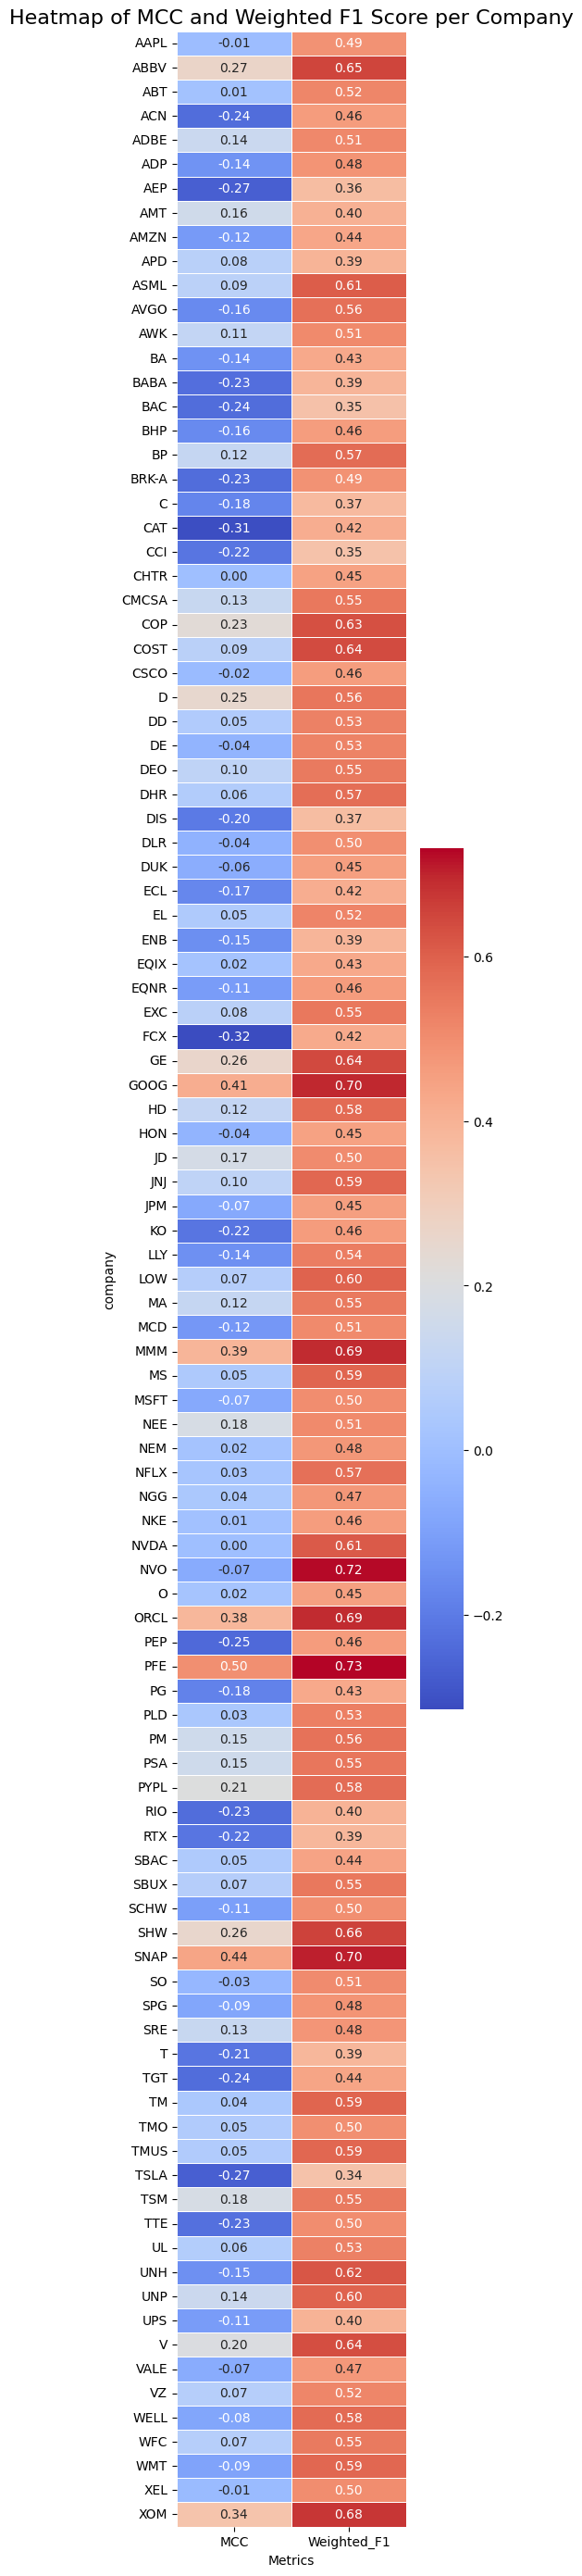

In [51]:
metrics_df.set_index('company', inplace=True)

# Plot heatmap
plt.figure(figsize=(4, 35))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')

# Add title and labels
plt.title('Heatmap of MCC and Weighted F1 Score per Company', fontsize=16)
plt.ylabel('company')
plt.xlabel('Metrics')

# Show the heatmap
plt.show()

In [30]:
# "meta/meta-llama-3-70b-instruct"
res, stats = evaluator(test_dict, "meta/meta-llama-3-8b")

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]

validated generations: 1.0
(array([0.71111111, 0.43636364]), array([0.50793651, 0.64864865]), array([0.59259259, 0.52173913]), array([63, 37]))
in evaluator {'P+-': [0.7111111111111111, 0.43636363636363634], 'R+-': [0.5079365079365079, 0.6486486486486487], 'f1s': [0.5925925925925924, 0.5217391304347827], 'wf1': 0.5663768115942028, 'ACC': 0.56, 'MCC': 0.15196169394189366}
